# MODEL - IMAGE LOADING & NEURAL NETWORK

In [1]:
pip install -r requirements.txt

  Using cached ansible-10.5.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached ansible_core-2.17.5-py3-none-any.whl.metadata (6.9 kB)
  Using cached boto3-1.35.44-py3-none-any.whl.metadata (6.7 kB)
  Using cached botocore-1.35.44-py3-none-any.whl.metadata (5.7 kB)
  Using cached cryptography-43.0.3-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached debugpy-1.8.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached fonttools-4.53.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached googleapis_common_protos-1.65.0-py2.py3-none-any.whl.metadata (1.5 kB)


  Using cached graphene-3.4-py2.py3-none-any.whl.metadata (6.7 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached multiprocess-0.70.17-py310-none-any.whl.metadata (7.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)


  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached pandocfilters-1.5.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached pathos-0.3.3-py3-none-any.whl.metadata (11 kB)
  Using cached pox-0.3.5-py3-none-any.whl.metadata (8.0 kB)
  Using cached ppft-1.7.6.9-py3-none-any.whl.metadata (12 kB)
  Using cached prompt_toolkit-3.0.47-py3-none-any.whl.metadata (6.4 kB)
  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
ERROR: Ignored the following versions that require a different python version: 11.0.0a1 Requires-Python >=3.11; 11.0.0a2 Requires-Python >=3.11; 2.18.0b1 Requires-Python >=3.11; 2.18.0rc1 Requires-Python >=3.11
ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching dist

In [2]:
#Import libraries
import boto3
import sagemaker
import fsspec
import gc
import csv
import os
import io
import cv2
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, auc, make_scorer, roc_curve
import tensorflow as tf
from tensorflow import keras
import keras_cv
import random
from collections.abc import Generator
import itertools
import datetime

TF_ENABLE_ONEDNN_OPTS=0

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


2024-10-26 16:11:53.484067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 16:11:53.712757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 16:11:53.714561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 16:11:54.086868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 16:11:55.926247: W tensorflow/com

Using TensorFlow backend


## 1) HYPERPARAMETERS

In [3]:
#Fraction of data to use (CEDRIC can reduce to speed up tests... go to 0.02!)
train_frac_to_use = 1   #Reduce training data to this fraction. Set to "1" to use all data.
val_frac_to_use = 1     #Reduce validation data to this fraction. Set to "1" to use all data.
test_frac_to_use = 1     #Reduce validation data to this fraction. Set to "1" to use all data.

#Memory management (Speeds up model. Need 16GB of RAM for validation data and likely 64GB of RAM for training data)
save_train_in_memory = False #Place all training data directly in memory to accelerate the validation step in the model
save_val_in_memory = True  #Place all validation data directly in memory to accelerate the validation step in the model

#Saves management (weights only, all other saves are performed by default)
wt_save_freq = 1 #Save model weights every X epochs. Set to 0 for no saving during epochs.
final_wt_save = True

#Splitting of train-validate-test
split_seed = 88                 #Seed to use for all train-validate-test splits, including the split of reserved Target=1 data
reserve_frac = 0.1              #Fraction of total original data of Target = 1 (reserved for use in validation data)
test_frac = 0.2                 #Fraction of total original data, excluding the reserved fraction, to use as the test data
nb_of_augments = 100            #Number of augments to perform on Target = 1 images in train-validate sets
val_frac = 0.33                 #Fraction of augmented train-validate list to use as the validation data. The rest becomes the training data.
nb_of_augments_reserved = 15    #Number of augmentations to perform on reserved validation fraction (Target = 1). Note: this is added to the validation data.
reduce_frac = 0.8               #Fraction of Target = 0 samples to remove from the validation data (improves balance)

#Image resizing: all images are adjusted to this size so the the CNN receives same number of data points each time
imgSize = 100

#Hair removal (applies to all images)
apply_hair_removal = True

#Batch sizes
train_batch_size = 32
val_batch_size = 32
test_batch_size = 32

#Choice of model
#0 = in series (convolutions on images followed by concatenation with metadata followed by deep NN layers, followed by final layer)
#1 = in parallel (metadata run separately in deep NN layers, then concatenated with results from image convolutions, followed by final layer)
model_choice = 1

#Neural Network Parameters
nb_neurons_hidden_layers = 36  #Number of neurons in each hidden layer
dropout = 0.1                  #Fraction of neurons to drop

#Optimizer Parameters
learning_rate = 0.005           #Initial learning rate for the Adam optimizer

#Epoch management (CEDRIC... reduce number of epochs if needed)
nb_epochs = 20
early_break = False #End early in case of increasing validation loss

#Debugging
cheat = False #add the target to the metadata so the model can precisely learn the correct response

## 2) IMPORT DATA & DECLARE SAVES

### 2.1 - Declare file paths

##### Local copy hdf5

In [4]:
# Configuration S3 et chemin local
session = sagemaker.Session()
bucket = 'images-projet-deep-learning-01'
hdf5_key = 'train-image.hdf5'
local_hdf5_path = os.path.join(os.getcwd(), 'train-image.hdf5')

# Vérifie si le fichier est déjà présent
if os.path.exists(local_hdf5_path):
    print(f"Le fichier {local_hdf5_path} existe déjà. Téléchargement sauté.")
else:
    # Télécharger le fichier HDF5 depuis S3
    print(f"Téléchargement de {hdf5_key} depuis S3 vers {local_hdf5_path}...")
    s3 = boto3.client('s3')
    s3.download_file(bucket, hdf5_key, local_hdf5_path)
    print("Téléchargement terminé.")

Le fichier /home/ec2-user/SageMaker/train-image.hdf5 existe déjà. Téléchargement sauté.


In [5]:
#IMPORT FILES
#Directory for data files - FULL DATA
dataPath = "s3://images-projet-deep-learning-01/" #slash required at end
#Metadata file paths
metaPath = dataPath + "cleaned-metadata.csv"
#Image file path
hdf5_file = "train-image.hdf5"

#SAVE FILES
#Directory for saved files 
# savePath = "s3://dsti-a23-deep-learning-outputs-01/" #slash required at end
folder = '/results/'
savePath = os.getcwd() + folder
#Model results
modelResPath = savePath + "model_results_save.csv"
#Test ids (isic_ids + target + mod_toggle)
test_ids_Path = savePath + "test_ids.csv"
#Test results (y_test, y_pred)
testResPath = savePath + "test_results_save.csv"

print(savePath)
print(testResPath)

/home/ec2-user/SageMaker/results/
/home/ec2-user/SageMaker/results/test_results_save.csv


### 2.2 - Load metadata from csv

In [6]:
#Import metadata from file
metadata = pd.read_csv(metaPath, sep=",")

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [7]:
#Verify that there are no NAs
print("-- X_meta NA counts --")
print(metadata.isna().sum())

-- X_meta NA counts --
isic_id                         0
target                          0
clin_size_long_diam_mm          0
tbp_lv_A                        0
tbp_lv_Aext                     0
tbp_lv_B                        0
tbp_lv_H                        0
tbp_lv_Hext                     0
tbp_lv_areaMM2                  0
tbp_lv_area_perim_ratio         0
tbp_lv_color_std_mean           0
tbp_lv_deltaB                   0
tbp_lv_deltaLBnorm              0
tbp_lv_minorAxisMM              0
tbp_lv_norm_color               0
tbp_lv_perimeterMM              0
tbp_lv_radial_color_std_max     0
tbp_lv_stdLExt                  0
tbp_lv_y                        0
tbp_lv_dnn_lesion_confidence    0
normalized_contrast             0
size_to_area_ratio              0
luminance_ratio                 0
chroma_B_ratio                  0
category_Head & Neck            0
dtype: int64


In [8]:
#Activate for debugging of the predict function
if cheat:
    metadata["target_cheat"] = metadata["target"]

In [9]:
#Calculate the total number of features in the metadata (subtract 'isic_id' and 'target')
num_features = len(metadata.columns)

## 3) Train, Validate, Test Split + Preparation of Data Augmentation
1. Make two separate lists of isic_ids for target=0 and target=1. Transform into tuples (isic_id, target, mod toggle). Base data has mod toggle = 0, meaning no adjustment will be made.
2. Reserve 10% of target = 1 for validate
3. Split into train-validate & test on both lists (0 and 1). Take the test lists (0 and 1), concatenate and shuffle them
4. Create augmentation preparation function for target = 1: mod toggle = strictly positive integer (this adds more isic_ids to the list, with mod toggle non zero))
5. Run augmentation preparation function on train-validate and the reserved validation data: mod toggle = strictly positive integer
6. Split train-validate on both lists (0 and 1)
7. Reduce the validation data on target = 0 by value specified in reduce_frac
8. Concatenate and shuffle the train lists and validation lists
9. Limit training and validation data to speed up training (take only fraction of prepared lists)

### 3.1 - Make two separate lists of isic_ids for target=0 (mod_toggle = -1) and target=1 (mod_toggle = 0)

In [10]:
#Make a list of isic_ids for each target value (0 and 1)
isic_id_target_0 = metadata[metadata['target'] == 0]['isic_id'].tolist()
isic_id_target_1 = metadata[metadata['target'] == 1]['isic_id'].tolist()

#Retrieve dataframe with isic id and target
temp_0 = metadata[metadata["isic_id"].isin(isic_id_target_0)].loc[:,["isic_id","target"]]
temp_1 = metadata[metadata["isic_id"].isin(isic_id_target_1)].loc[:,["isic_id","target"]]

#Convert into list of tuples... this makes it compatible with data augmentations
#Form: (isic_id, target, mod toggle)
isic_id_target_0 = list(zip(temp_0.iloc[:,0], temp_0.iloc[:,1], [-1]*len(temp_0)))
isic_id_target_1 = list(zip(temp_1.iloc[:,0], temp_1.iloc[:,1], [0]*len(temp_1)))

#Delete temporary dataframes (the original metadata dataframe is untouched)
del temp_0
del temp_1

#Count the number of occurrences for each target value
print("Total ids with target = 0:", len(isic_id_target_0))
print("Total ids with target = 1:", len(isic_id_target_1))

Total ids with target = 0: 381533
Total ids with target = 1: 381


### 3.2 - Reserve 10% of target = 1 for validate

In [11]:
#Keep 10% of isic_Id of target=1 without duplication
isic_id_target_1, isic_id_target_1_reserved = train_test_split(isic_id_target_1, test_size = reserve_frac, random_state=split_seed, shuffle=False)

#Count the number of occurrences for each target value (AFTER RESERVATION)
print("Total ids with target = 0:", len(isic_id_target_0))
print("Total ids with target = 1:", len(isic_id_target_1))
print("Total reserved target = 1:", len(isic_id_target_1_reserved))

Total ids with target = 0: 381533
Total ids with target = 1: 342
Total reserved target = 1: 39


### 3.3 - Split into train-validate & test on both lists (0 and 1). Take the test lists (0 and 1), concatenate and shuffle them

In [12]:
#Split out the test ids
trainval_0, test_0 = train_test_split(isic_id_target_0, test_size = test_frac, random_state=split_seed, shuffle=True)
trainval_1, test_1 = train_test_split(isic_id_target_1, test_size = test_frac, random_state=split_seed, shuffle=True)

test_ids = test_0 + test_1
np.random.shuffle(test_ids)

### 3.4 - Create augmentation preparation function for target = 1: mod toggle = strictly positive integer
(this adds more isic_ids to the list, with mod toggle non zero))

In [13]:
#Generate a list containing augmentation toggles. Apply only to training and validation sets.
def augment_prep(tuple_list, nb_of_augments = 30, shuffle_seed=None):
    augment_list = []
    
    #If augmentation is desired, then the mod toggle is a strictly positive integer
    augment_list = [(item[0], item[1], i) for item in tuple_list for i in range(1, nb_of_augments + 1)]
    
    #Shuffle the list
    augment_list.extend(tuple_list)
    np.random.seed(shuffle_seed)
    np.random.shuffle(augment_list)

    return augment_list

### 3.5 - Run augmentation preparation function on train-validate and the reserved validation data: mod toggle = strictly positive integer

In [14]:
#Augment the training and validation list
trainval_1 = augment_prep(trainval_1, nb_of_augments=nb_of_augments, shuffle_seed=50)

#Duplicate the reserved training data
reserved_1 = augment_prep(isic_id_target_1_reserved, nb_of_augments=nb_of_augments_reserved, shuffle_seed=50)

### 3.6 - Split train-validate on both lists (0 and 1)

In [15]:
#Split training and validation lists
train_0, val_0 = train_test_split(trainval_0, test_size = val_frac, random_state=split_seed, shuffle=True)
train_1, val_1 = train_test_split(trainval_1, test_size = val_frac, random_state=split_seed, shuffle=True)

### 3.7 - Reduce the validation data on target = 0 by value specified in reduce_frac

In [16]:
#Reduce the validation data of type Target = 0
nb_samples = int((1 - reduce_frac) * len(val_0))
val_0 = random.sample(val_0, nb_samples)

### 3.8 - Concatenate and shuffle the train and validation lists

In [17]:
#Concatenate
train_ids=train_0.copy()
train_ids.extend(train_1)
val_ids=list(itertools.chain(val_0, val_1, reserved_1))

#Shuffle
np.random.seed(60)
np.random.shuffle(train_ids)
np.random.shuffle(val_ids)

In [18]:
#Calculate the proportaion of Target=1 in each set (training, validation, test)
def calc_frac_target1(ids):
    return sum([item[1] for item in ids]) / len(ids)

tot_samples = len(train_ids) + len(val_ids) + len(test_ids)

print("Train/Validate/Test Counts:", len(train_ids), "/", len(val_ids), "/", len(test_ids))
print("Train/Validate/Test Fractions:", round(len(train_ids)/tot_samples,2), "/", round(len(val_ids)/tot_samples,2), "/", round(len(test_ids)/tot_samples,2))
print("Proportion of Target = 1 in training data:", calc_frac_target1(train_ids))
print("Proportion of Target = 1 in validation data:", calc_frac_target1(val_ids))
print("Proportion of Target = 1 in test data:", calc_frac_target1(test_ids))

Train/Validate/Test Counts: 222974 / 29868 / 76376
Train/Validate/Test Fractions: 0.68 / 0.09 / 0.23
Proportion of Target = 1 in training data: 0.08284822445666311
Proportion of Target = 1 in validation data: 0.3255658229543324
Proportion of Target = 1 in test data: 0.0009034251597360428


### 3.9 - Limit training and validation data to speed up training

In [19]:
#Choose a portion of TRAINING ids to load into memory
def take_fewer_samples(ids, frac_to_use, seed):
    if frac_to_use < 1 and frac_to_use > 0:
        random.seed(seed)
        k = int(frac_to_use * len(ids))
        ids_short = random.choices(ids, k=k)
        return ids_short
    return ids

print("Train ids length before:", len(train_ids))
train_ids = take_fewer_samples(train_ids, train_frac_to_use, seed=12)
print("Train ids length after:", len(train_ids))

print("Validate ids length before:", len(val_ids))
val_ids = take_fewer_samples(val_ids, val_frac_to_use, seed=12)
print("Validate ids length after:", len(val_ids))

print("Test ids length before:", len(test_ids))
test_ids = take_fewer_samples(test_ids, test_frac_to_use, seed=12)
print("Test ids length after:", len(test_ids))

Train ids length before: 222974
Train ids length after: 222974
Validate ids length before: 29868
Validate ids length after: 29868
Test ids length before: 76376
Test ids length after: 76376


## 4) Augmentation functions (used during dataset creation)

In [20]:
def hair_removal(image, crop_pixels=10):
    height_pixels = len(image)  # Image rows
    width_pixels = len(image[0])  # Image columns

    # Image cropping
    height = [crop_pixels, height_pixels - crop_pixels]
    width = [crop_pixels, width_pixels - crop_pixels]
    img = image[height[0]:height[1], width[0]:width[1]]

    # Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Black hat filter
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    # Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    # Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    return dst

In [21]:
# Define the augmentation function
def augment_image(image, mod_toggle, is_training=False):
    """
    Apply a series of augmentations to create diverse variations of the input image.
    Includes random flips, rotations, brightness adjustments, and other transformations.
    """

    # Parameters
    if is_training==True:
        #Cutout values
        height_factor_cut=(0.02, 0.06)
        width_factor_cut=(0.02, 0.06)
        random_cutout = keras_cv.layers.RandomCutout(height_factor=height_factor_cut, width_factor=width_factor_cut)
        #Brightness values
        min_delta_bright=0.05
        max_delta_bright=0.25
        #Saturation values
        weak_sat_low=0.7
        weak_sat_high=0.95
        strong_sat_low=1.05
        strong_sat_high=1.8
        #Contrast values
        weak_cont_low=0.7
        weak_cont_high=0.95
        strong_cont_low=1.05
        strong_cont_high=1.8

    else:
        #Brightness values
        min_delta_bright=0.05
        max_delta_bright=0.15
        #Saturation values
        weak_sat_low=0.8
        weak_sat_high=0.95
        strong_sat_low=1.05
        strong_sat_high=1.2
        #Contrast values
        weak_cont_low=0.8
        weak_cont_high=0.95
        strong_cont_low=1.05
        strong_cont_high=1.2

    #List of base augmentations
    base_augments = [
        lambda img: tf.image.flip_left_right(img),
        lambda img: tf.image.flip_up_down(img),
        lambda img: tf.image.rot90(img, k=1),
        lambda img: tf.image.rot90(img, k=2),
        lambda img: tf.image.rot90(img, k=3),
        lambda img: random_cutout(img)
    ]

    #List of other augmentations that can be performed multiple times
    other_augments = [
        lambda img: tf.image.adjust_brightness(img, -random.uniform(min_delta_bright, max_delta_bright)),
        lambda img: tf.image.adjust_brightness(img, random.uniform(min_delta_bright, max_delta_bright)),
        lambda img: tf.image.random_contrast(img, lower=weak_cont_low, upper=weak_cont_high),
        lambda img: tf.image.random_contrast(img, lower=strong_cont_low, upper=strong_cont_high),
        lambda img: tf.image.random_saturation(img, lower=weak_sat_low, upper=weak_sat_high),
        lambda img: tf.image.random_saturation(img, lower=strong_sat_low, upper=strong_sat_high)
    ]

    #Select augmentations to use based on whether it is training data or not
    if is_training:
        base_augments = base_augments
        other_augments = other_augments 
    else:
        base_selection = [0,1]  #Positions of the augmentations to use in the base_augments list
        base_augments = [base_augments[i] for i in base_selection]
        other_augments = other_augments

    #Engage the augment based on the mod_toggle. The base_augments are always done first.
    nb_base_aug = len(base_augments)
    
    if mod_toggle <= nb_base_aug and mod_toggle > 0:
        augmentation = base_augments[mod_toggle - 1] #Mod toggles start at 1
        image = augmentation(image)
    else:
        augmentation = random.choice(other_augments)
        image = augmentation(image)
        #Apply a second transformation with a certain probability
        if tf.random.uniform([]) < 0.85:
            augmentation2 = random.choice(base_augments)
            image = augmentation2(image)
    
    return image

In [22]:
#TESTING OF AUGMENT_IMAGE FUNCTION
"""
id_try = "ISIC_5675460"
with h5py.File(hdf5_file, 'r') as h5file:
    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))

for mod_toggle in range(500):
    img = hair_removal(img_try)
    img = cv2.resize(img, (100, 100), interpolation= cv2.INTER_AREA)
    augment_image(img, mod_toggle, is_training=True)
"""

'\nid_try = "ISIC_5675460"\nwith h5py.File(hdf5_file, \'r\') as h5file:\n    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))\n\nfor mod_toggle in range(500):\n    img = hair_removal(img_try)\n    img = cv2.resize(img, (100, 100), interpolation= cv2.INTER_AREA)\n    augment_image(img, mod_toggle, is_training=True)\n'

In [23]:
# TESTING OF BASE AUGMENTS
"""
id_try = "ISIC_5675460"
with h5py.File(hdf5_file, 'r') as h5file:
    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))

height_factor_cut=(0.02, 0.06)
width_factor_cut=(0.02, 0.06)
random_cutout = keras_cv.layers.RandomCutout(height_factor=height_factor_cut, width_factor=width_factor_cut)

base_augments = [
    lambda img: img,
    lambda img: tf.image.flip_left_right(img),
    lambda img: tf.image.flip_up_down(img),
    lambda img: tf.image.rot90(img, k=1),
    lambda img: tf.image.rot90(img, k=2),
    lambda img: tf.image.rot90(img, k=3),
    lambda img: random_cutout(img).numpy().astype(int),
]

images = []
for augmentation in base_augments:
    image = augmentation(img_try)
    images.append(image)

#Show the images
for image in images:
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()
"""

'\nid_try = "ISIC_5675460"\nwith h5py.File(hdf5_file, \'r\') as h5file:\n    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))\n\nheight_factor_cut=(0.02, 0.06)\nwidth_factor_cut=(0.02, 0.06)\nrandom_cutout = keras_cv.layers.RandomCutout(height_factor=height_factor_cut, width_factor=width_factor_cut)\n\nbase_augments = [\n    lambda img: img,\n    lambda img: tf.image.flip_left_right(img),\n    lambda img: tf.image.flip_up_down(img),\n    lambda img: tf.image.rot90(img, k=1),\n    lambda img: tf.image.rot90(img, k=2),\n    lambda img: tf.image.rot90(img, k=3),\n    lambda img: random_cutout(img).numpy().astype(int),\n]\n\nimages = []\nfor augmentation in base_augments:\n    image = augmentation(img_try)\n    images.append(image)\n\n#Show the images\nfor image in images:\n    plt.imshow(image, interpolation=None)\n    plt.grid(None)\n    plt.show()\n'

In [24]:
#TESTING OF OTHER AUGMENTS
"""
id_try = "ISIC_5675460"
with h5py.File(hdf5_file, 'r') as h5file:
    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))

#Brightness values
min_delta_bright=0.05
max_delta_bright=0.25
#Saturation values
weak_sat_low=0.7
weak_sat_high=0.95
strong_sat_low=1.05
strong_sat_high=1.8
#Contrast values
weak_cont_low=0.7
weak_cont_high=0.95
strong_cont_low=1.05
strong_cont_high=1.8

#List of other augmentations that can be performed multiple times
other_augments = [
    lambda img: tf.image.adjust_brightness(img, -random.uniform(min_delta_bright, max_delta_bright)),
    lambda img: tf.image.adjust_brightness(img, random.uniform(min_delta_bright, max_delta_bright)),
    lambda img: tf.image.random_contrast(img, lower=weak_cont_low, upper=weak_cont_high),
    lambda img: tf.image.random_contrast(img, lower=strong_cont_low, upper=strong_cont_high),
    lambda img: tf.image.random_saturation(img, lower=weak_sat_low, upper=weak_sat_high),
    lambda img: tf.image.random_saturation(img, lower=strong_sat_low, upper=strong_sat_high)
]

images = []
for augmentation in other_augments:
    image = augmentation(img_try)
    if tf.random.uniform([]) < 1:
        augmentation2 = random.choice(base_augments)
        image = augmentation2(image)
    images.append(image)

#Show the images
for image in images:
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()
"""

'\nid_try = "ISIC_5675460"\nwith h5py.File(hdf5_file, \'r\') as h5file:\n    img_try = np.array(Image.open(io.BytesIO(h5file[id_try][()])))\n\n#Brightness values\nmin_delta_bright=0.05\nmax_delta_bright=0.25\n#Saturation values\nweak_sat_low=0.7\nweak_sat_high=0.95\nstrong_sat_low=1.05\nstrong_sat_high=1.8\n#Contrast values\nweak_cont_low=0.7\nweak_cont_high=0.95\nstrong_cont_low=1.05\nstrong_cont_high=1.8\n\n#List of other augmentations that can be performed multiple times\nother_augments = [\n    lambda img: tf.image.adjust_brightness(img, -random.uniform(min_delta_bright, max_delta_bright)),\n    lambda img: tf.image.adjust_brightness(img, random.uniform(min_delta_bright, max_delta_bright)),\n    lambda img: tf.image.random_contrast(img, lower=weak_cont_low, upper=weak_cont_high),\n    lambda img: tf.image.random_contrast(img, lower=strong_cont_low, upper=strong_cont_high),\n    lambda img: tf.image.random_saturation(img, lower=weak_sat_low, upper=weak_sat_high),\n    lambda img: tf

## 5) Metadata Dictionary

In [25]:
#Create a metadata dictionary for efficient lookup
#Structure: {index: value} where value is (mod_toggle, metadata array)

#Objective: We need "train_ids" to efficiently retrieve and augment images from the HDF5 file. This already exists.
#           We need to accesss metadata through a dictionary to improve speed. A common reference is needed for both.

#Idea:      Since train_ids is a LIST of tuples (isic_id, target, mod toggle), it is accessed via indices (ex. train_ids[10]).
#           We need to make a dictionary that, for each train_ids index, lists all the metadata associated to the isic_id.
#           Thus, when train_ids[10] is called, we call the dictionary and request key=10 to get the metadata.
#           Result: very fast data retrieval

def make_meta_dict(metadata, isic_ids_tuple):
    #Reindex. The metadata must be contiguously indexed. Holes in index numbering will not work.
    metadata = metadata.reset_index(drop=True)

    #Get the column number for "isic_id" and "target" in the metadata dataframe.
    #This allows us to know where these items are located in the metadata retrieved for each item.
    #This is used later to filter out these items from the metadata.
    col_num_id = metadata.columns.get_loc("isic_id")
    col_num_target = metadata.columns.get_loc("target")

    #The metadata contains all unique isic_ids. Since the dataframe is reindexed, it is possible to make
    #a dictionary of (isic_id: row number) for fast retrieval of all metadata associated to an isic_id.

    #Take the metadata dataframe and create a dictionary that stores (isic_id, row number).
    metadata_index_dict = metadata["isic_id"].to_dict()
    metadata_index_dict = dict((v, k) for k, v in metadata_index_dict.items())

    #Make a dictionary of (index: (mod toggle, metadata)), where index is the position of a sample in train_ids and metadata is the metadata
    #associated to the sample's isic_id. We thus create a dict_of_meta that is a mirror image of the "isic_ids_tuple" list.
    #We must be careful to not shuffle "isic_ids_tuple".
    dict_of_meta = {}
    for pos, tup in enumerate(isic_ids_tuple):
        # Use the lookup table to directly find the index
        index = metadata_index_dict.get(tup[0], -1)  # -1 if not found

        if index != -1:
            # Access the row directly without masking
            dict_of_meta.update({pos: (tup[2], np.array(metadata.iloc[index].values))})
            # Process the row as needed
        else:
            raise Exception("isic_id values are not all unique")
    return dict_of_meta, col_num_id, col_num_target

In [26]:
#Create the metadata dictionaries for train-validate-test
train_meta_dict, train_pos_isic_id, train_pos_target = make_meta_dict(metadata, train_ids)
val_meta_dict, val_pos_isic_id, val_pos_target = make_meta_dict(metadata, val_ids)
test_meta_dict, test_pos_isic_id, test_pos_target = make_meta_dict(metadata, test_ids)

In [27]:
#Look some dictionary elements to understand the structure {index, (mod_toggle, metadata)}
print("SAMPLE OF ITEMS FROM VALIDATION META DICTIONARY")
dict(filter(lambda item: item[0] in {0, 1, 2}, val_meta_dict.items()))

SAMPLE OF ITEMS FROM VALIDATION META DICTIONARY


{0: (61,
  array(['ISIC_6397037', 1, 2.4382335136397706, 0.22812746467181,
         -1.1126160012299564, -1.011203855248917, -1.2582703065867809,
         0.8349987470947446, 3.747163237103989, -0.747354368588485,
         2.0859385674302127, -1.2467653122094744, 5.217041355676107,
         3.809504258600349, 1.3897054479733373, 2.3784811335709235,
         0.4190379680040542, 0.0509311228974838, 0.7907118881952164,
         0.3162400822235623, -2.562333125172432, -1.9705527372684155,
         -5.3034176978504535, -1.2782249290621466, 0], dtype=object)),
 1: (-1,
  array(['ISIC_4420035', 0, -0.4775966954281103, -0.9913796393234418,
         -0.626776602175792, -0.255226191343274, 0.8364706406522436,
         0.2740460700675186, -0.5616945679287801, -0.0157442749562496,
         -1.4040674715875925, 0.4979518899980893, -0.8952602052786262,
         -1.256532386064231, -1.5126717561761245, -0.7071744158518197,
         -1.3848528487599947, -0.5591509683837209, -0.7763821819884091,
      

## 6) Dataset generation function

In [28]:
#IMAGE generator in a class
class hdf5_generator_all_included(Generator):
    def __init__(self, file, meta_dict, dict_pos_isic_id, dict_pos_target, num_features, imgSize, is_training=False, shuffle_seed=None, apply_hair_removal=False):
        self.file = file
        self.meta_dict = meta_dict
        self.pos_mod_toggle = 0                     #Position of 'mod_toggle' within dictionary: structure {key: value} where value is (mod_toggle, metadata array)
        self.pos_metadata_array = 1                 #Position of 'metadata array' within dictionary: structure {key: value} where value is (mod_toggle, metadata array)
        self.dict_pos_isic_id = dict_pos_isic_id    #Set position of 'isic_id" within the metadata array: structure [var0, var1, var2, var3, ...]
        self.dict_pos_target = dict_pos_target      #Set position of 'target" within the metadata array: structure [var0, var1, var2, var3, ...]
        self.num_features = num_features
        self.imgSize = imgSize
        self.is_training = is_training
        self.shuffle_seed = shuffle_seed
        self.apply_hair_removal = apply_hair_removal
        self.len = len(meta_dict)
        self.start = 0
        self.stop = self.len
        self.i = self.start
        self.error_check()
        self.open_hdf5()
        self.order_and_shuffle()
        
    def send(self, value):
        if self.i < self.stop:
            if self.i == self.start:
                self.open_hdf5()

            #Retrieve index of isic_id according to the shuffled order
            index = self.order[self.i]

            #Retrieve target... remember that each item of the the meta_dict is a tuple of (mod toggle, metadata)
            target = self.meta_dict[index][self.pos_metadata_array][self.dict_pos_target]
            target = np.reshape(target, (1,1))
            target = tf.cast(target, dtype=tf.int32)

            #Retrieve metadata... remember that each item of the the meta_dict is a tuple of (mod toggle, metadata)
            meta = np.delete(self.meta_dict[index][self.pos_metadata_array], [self.dict_pos_isic_id, self.dict_pos_target], 0)
            meta = meta.astype(dtype=float)
            meta = tf.cast(meta, dtype=tf.float32)
            meta = tf.reshape(meta, shape=(1, self.num_features))

            try:
                #Retrieve isic_id
                img_name = self.meta_dict[index][self.pos_metadata_array][self.dict_pos_isic_id]
                
                # Load image data from HDF5
                img = np.array(Image.open(io.BytesIO(self.h5file[img_name][()])))

                # Clean image
                if self.apply_hair_removal:
                    img = hair_removal(img)

                # Resize the image
                img = cv2.resize(img, (self.imgSize, self.imgSize), interpolation= cv2.INTER_AREA)

                # Apply augmentations if needed
                mod_toggle = self.meta_dict[index][self.pos_mod_toggle]
                if mod_toggle > 0:
                    img=augment_image(img, mod_toggle, self.is_training)
                    
                # Standardize and return as TensorFlow constant
                img = tf.constant(img / 255, dtype=tf.float32)
                
                #Augment counter
                self.i = self.i + 1
                return (img, meta), target
            
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                # log the error to a file for later analysis
                with open('image_errors.log', 'a') as f:
                    f.write(f"Error loading image {img_name}: {e}\n")

            if self.i == self.stop:
                self.h5file.close()
        raise StopIteration

    def throw(self, typ, val=None, tb=None):
        #Close HDF5 file and terminate generator
        try:
            self.h5file.close()
            super().throw(typ, val, tb)
        except:
            super().throw(typ, val, tb)

    def error_check(self):
        #Seed type check
        try:
            int(self.shuffle_seed) == self.shuffle_seed
        except:
            if self.shuffle_seed != None:
                raise Exception("Seed must either be an integer or None")

    def order_and_shuffle(self):
        np.random.seed(self.shuffle_seed)
        self.order = np.array(list(self.meta_dict.keys()), dtype=int)
        if self.shuffle_seed != None:
            np.random.shuffle(self.order)

    def open_hdf5(self):
        self.h5file = h5py.File(self.file, 'r')

In [29]:
def make_dataset(hdf5_file, meta_dict, dict_pos_isic_id, dict_pos_target, imgSize=100, batch_size=32, is_training=False, shuffle_seed = None, apply_hair_removal=False):
    num_features = len(val_meta_dict[0][1]) - 2 #Subtract isic_id and target

    combined_generator = hdf5_generator_all_included(hdf5_file, meta_dict, dict_pos_isic_id, dict_pos_target, num_features, imgSize, is_training, shuffle_seed, apply_hair_removal)

    # Generate image dataset
    element_spec = ((tf.TensorSpec(shape=(imgSize, imgSize, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(1, num_features), dtype=tf.float32)),
                    tf.TensorSpec(shape=(1, 1), dtype=tf.int32))


    img_dataset = tf.data.Dataset.from_generator(
        lambda: combined_generator,
        output_signature=element_spec
    )

    return img_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## 7) Alternative dataset function to load all in memory (not a generator)

In [30]:
def make_in_memory_dataset(hdf5_file, meta_dict, dict_pos_isic_id, dict_pos_target, imgSize=100, batch_size=32, is_training=False, shuffle_seed=None, apply_hair_removal=False):
    #Position of elements in the value part of the dictionary (it is a tuple with multiple elements)
    pos_mod_toggle = 0
    pos_metadata_array = 1

    num_features = len(meta_dict[0][pos_metadata_array]) - 2  # Subtract isic_id and target columns

    # Initialize lists to hold images, metadata, and targets
    images = []
    metas = []
    targets = []

    np.random.seed(shuffle_seed)
    order = np.array(list(meta_dict.keys()), dtype=int)
    if shuffle_seed is not None:
        np.random.shuffle(order)
        
    with h5py.File(hdf5_file, 'r') as h5file:
        for i in range(len(meta_dict)):
            index = order[i]
            
            # Retrieve target
            target = meta_dict[index][pos_metadata_array][dict_pos_target]
            target = np.reshape(target, (1, 1))
            target = tf.cast(target, dtype=tf.int32)

            # Retrieve metadata
            meta = np.delete(meta_dict[index][pos_metadata_array], [dict_pos_isic_id, dict_pos_target], 0)
            meta = meta.astype(dtype=float)
            meta = tf.cast(meta, dtype=tf.float32)
            meta = tf.reshape(meta, shape=(1, num_features))

            try:
                # Retrieve isic_id and load image
                img_name = meta_dict[index][pos_metadata_array][dict_pos_isic_id]
                
                # Load image data from HDF5
                img = np.array(Image.open(io.BytesIO(h5file[img_name][()])))

                # Clean image
                if apply_hair_removal:
                    img = hair_removal(img)

                # Resize the image
                img = cv2.resize(img, (imgSize, imgSize), interpolation=cv2.INTER_AREA)

                # Apply augmentations if needed
                mod_toggle = meta_dict[index][pos_mod_toggle]
                if mod_toggle > 0:
                    img=augment_image(img, mod_toggle, is_training)

                # Normalize the image
                img = tf.constant(img / 255, dtype=tf.float32)

                # Add processed data to lists
                images.append(img)
                metas.append(meta)
                targets.append(target)

            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                with open('image_errors.log', 'a') as f:
                    f.write(f"Error loading image {img_name}: {e}\n")
                continue

    # Convert lists to tensors
    images_tensor = tf.stack(images, axis=0)
    metas_tensor = tf.stack(metas, axis=0)
    targets_tensor = tf.stack(targets, axis=0)

    # Combine the images, metadata, and targets into a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(((images_tensor, metas_tensor), targets_tensor))

    # Batch and prefetch the dataset
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## 8) CNN MODEL

### 8.1 - Model class

In [31]:
#Hybrid CNN model than runs images through convolutional layers, then concatenates output with metadata, and runs the data through a NN
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="KernelMult")
class Hybrid_model_series(tf.keras.Model):
    def __init__(self, neurons, dropout, num_features, activ = 'leaky_relu', img_size = 100, img_channels = 3, **kwargs):
        #Run the constructor of the parent class
        super(). __init__(**kwargs)
        
        #Save inputs
        self.neurons = neurons
        self.dropout = dropout
        self.activ = activ
        self.img_size = img_size
        self.img_channels = img_channels
        self.num_features = num_features

        #Weight and bias initializers
        self.kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        self.bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

        #Layers
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu', padding='same', input_shape=(self.img_size, self.img_size, self.img_channels),
                                            kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.conv2 = tf.keras.layers.Conv2D(64, 5, activation='relu', kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(self.neurons, activation = self.activ, kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.dropout1 = tf.keras.layers.Dropout(self.dropout)
        self.dense2 = tf.keras.layers.Dense(self.neurons, activation = self.activ, kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout)
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.concatenate = keras.layers.Concatenate(axis=1)
    
    def call(self, inputs, training=False):
        flattened_inputs = tf.nest.flatten(inputs)
        x_image, x_meta = flattened_inputs
        # Convolutions & pooling
        x = self.conv1(x_image)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        # Flattening of images and concatenation with other data
        x = self.flatten(x)
        # Reshape metadata to match dimensions
        x_meta = keras.layers.Reshape(target_shape=([x_meta.shape[-1]]))(x_meta)
        # Concatenate image and metadata
        x_all = self.concatenate([x, x_meta])
        # Neural Network
        x_all = self.dense1(x_all)
        x_all = self.dropout1(x_all, training=training)
        x_all = self.dense2(x_all)
        x_all = self.dropout2(x_all, training=training)
        output = self.dense3(x_all)
        return output

In [32]:
#Hybrid CNN model than runs metadata through a NN, images through convolutional layers, then concatenates results before a final layer (1 neuron)
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="KernelMult")
class Hybrid_model_parallel(tf.keras.Model):
    def __init__(self, neurons, dropout, num_features, activ = 'leaky_relu', img_size = 100, img_channels = 3, **kwargs):
        #Run the constructor of the parent class
        super(). __init__(**kwargs)
        
        #Save inputs
        self.neurons = neurons
        self.dropout = dropout
        self.activ = activ
        self.img_size = img_size
        self.img_channels = img_channels
        self.num_features = num_features

        #Weight and bias initializers
        self.kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        self.bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

        #Convolution Layers
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu', padding='same', input_shape=(self.img_size, self.img_size, self.img_channels),
                                            kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.conv2 = tf.keras.layers.Conv2D(64, 5, activation='relu', kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.flatten = tf.keras.layers.Flatten()

        #Neural network layers (metadata)
        self.dense1 = tf.keras.layers.Dense(self.neurons, activation = self.activ, input_shape=(1,self.num_features), kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.dropout1 = tf.keras.layers.Dropout(self.dropout)
        self.dense2 = tf.keras.layers.Dense(self.neurons, activation = self.activ, kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout)

        #Final layer
        self.concatenate = keras.layers.Concatenate(axis=1)
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=self.kernel_initializer, bias_initializer=self.bias_initializer)
    
    def call(self, inputs, training=False):
        flattened_inputs = tf.nest.flatten(inputs)
        x_image, x_meta = flattened_inputs
        #CONVOLUTIONAL LAYERS (IMAGES)
        # Convolutions & pooling
        x1 = self.conv1(x_image)
        x1 = self.pool(x1)
        x1 = self.conv2(x1)
        x1 = self.pool(x1)
        # Flattening of images and concatenation with other data
        x1 = self.flatten(x1)

        #NEURAL NETWORK LAYERS (METADATA ONLY)
        # Neural Network
        x2 = keras.layers.Reshape(target_shape=([x_meta.shape[-1]]))(x_meta)
        x2 = self.dense1(x2)
        x2 = self.dropout1(x2, training=training)
        x2 = self.dense2(x2)
        x2 = self.dropout2(x2, training=training)

        #FINAL LAYER (OUTPUT)
        # Concatenate image and metadata
        x_all = self.concatenate([x1, x2])
        output = self.dense3(x_all)
        return output

### 8.2 - Model compiling

In [33]:
#Set seed
tf.random.set_seed(71)

#Initialize model
if model_choice == 0:
    model = Hybrid_model_series(neurons=nb_neurons_hidden_layers, dropout=dropout, num_features=num_features, activ='leaky_relu')
else:
    model = Hybrid_model_parallel(neurons=nb_neurons_hidden_layers, dropout=dropout, num_features=num_features, activ='leaky_relu')


#Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                          label_smoothing=0.0,
                                          axis=-1,
                                          reduction='sum_over_batch_size',
                                          name='binary_crossentropy')

#Compile the model with loss, optimizer, and metrics
model.compile(loss = loss,
              optimizer = optimizer,
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.AUC(curve='ROC', name='AUC_ROC'),
                  tf.keras.metrics.AUC(curve='PR', name='AUC_PR'),
                  ]
)

2024-10-26 16:12:40.325989: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### 8.3 - Model loss function weights

In [34]:
#Define function to calculate weights to use in loss function
def compute_class_weights(meta_dict, pos_target):
    # Initialize counters for target=0 and target=1
    target_0_count = 0
    target_1_count = 0

    # Calculate total number of images
    total = len(meta_dict)
    # Calculate number of target = 1 by summing the target value for each dict item
    target_1_count = sum([meta_dict[key][1][pos_target] for key in range(total)])
    # Calculate number of target = 1
    target_0_count = total - target_1_count

    # Calculate class weights based on the counts, avoid division by zero
    if target_1_count > 0 :
        if target_1_count < target_0_count:
            weight_for_0 = 1
            weight_for_1 = target_0_count/target_1_count
        elif target_0_count > 0:
            weight_for_0 = target_1_count/target_0_count
            weight_for_1 = 1
        else:
            weight_for_0 = 0
            weight_for_1=target_1_count
    else:
        weight_for_0 = target_0_count
        weight_for_1 = 0
        

    return weight_for_0, weight_for_1

In [35]:
#Get weights for training
weight_for_0, weight_for_1 = compute_class_weights(train_meta_dict, train_pos_target)

### 8.4 - Model Fit

In [36]:
#Determine the number of batches (includes last incomplete batch)
nb_training_batches = int(np.ceil(len(train_meta_dict)/train_batch_size))
nb_validate_batches = int(np.ceil(len(val_meta_dict)/val_batch_size))

#Print results
print("Total training batches in dataset:", nb_training_batches)
print("Total validate batches in dataset:", nb_validate_batches)

Total training batches in dataset: 6968
Total validate batches in dataset: 934


In [37]:
#Load training dataset into memory to speed up the model
if save_train_in_memory:
    train_in_memory = make_in_memory_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target, apply_hair_removal=apply_hair_removal)

In [38]:
#Load validation dataset into memory to speed up the validation steps of the model
if save_val_in_memory:
    val_in_memory = make_in_memory_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target, apply_hair_removal=apply_hair_removal)

In [39]:
#Clear the memory leak in Keras
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()
    #print(f"Epoch {epoch+1} finished. Validation loss: {logs['val_loss']}")

In [40]:
#Run the model through epochs
'''
for epoch in range(1, nb_epochs + 1):
    #Make datasets
    print("EPOCH", epoch)

    #Reinitialize the training dataset with a new shuffle each time
    shuffle_seed = 8 + epoch #Next initialization of datasets will have a different shuffle
    
    #Reinitialize dataset generators (case when the dataset is not all stored in RAM)
    if save_train_in_memory == False:
        train_dataset = make_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target, batch_size = train_batch_size, is_training=True, shuffle_seed=shuffle_seed, apply_hair_removal=apply_hair_removal)
    if save_val_in_memory == False:
        val_dataset = make_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target, batch_size = val_batch_size, is_training=False, shuffle_seed=shuffle_seed, apply_hair_removal=apply_hair_removal)


    #Fit the model, using validation data either stored in memory or on the hard disk
    if save_val_in_memory:
        if save_train_in_memory:
            mod = model.fit(train_in_memory, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_in_memory, validation_steps = nb_validate_batches, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
        else:
            mod = model.fit(train_dataset, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_in_memory, validation_steps = nb_validate_batches, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
    else:
        if save_train_in_memory:
            mod = model.fit(train_in_memory, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_dataset, validation_steps = nb_validate_batches, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
        else:
            mod = model.fit(train_dataset, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_dataset, validation_steps = nb_validate_batches, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
    
    #Save results
    if epoch == 1:
        results = mod.history
    else:
        for key in mod.history:   
            results[key] += mod.history[key]
            
    #Export model structure (json) - REIMPORT NOT WORKING
    """
    if epoch == 1:
        model_json = model.to_json()
        with open(savePath + "model.json", "w") as json_file:
            json_file.write(model_json)
    """
    
    #Export weights (occassionally    
    if wt_save_freq > 0:
        if (epoch % wt_save_freq == 0):
            #if apply_hair_removal:
            #    modifier = "with_hair_removal_"
            #else:
            #    modifier = "no_hair_removal_"
            #now = datetime.datetime.now()
            #filename = "Model_" + modifier + "Epoch_" + str(epoch) + "_" + now.strftime("%Y-%m-%d_%Hh%Mm%Ss") + ".weights.h5"
            filename = "Model_" + "Epoch_" + str(epoch) + ".weights.h5"
            model.save_weights(savePath + filename)
    if final_wt_save and epoch == nb_epochs:
        filename = "Model_" + "Last_Epoch" + ".weights.h5"
        model.save_weights(savePath + filename)
    

    #Clean memory after use
    del mod
    #If save_val_in_memory is false, we have a generator. In this case, we want to delete the generator.
    if save_train_in_memory == False:
        del train_dataset
    #If save_val_in_memory is false, we have a generator. In this case, we want to delete the generator.
    if save_val_in_memory == False:
        del val_dataset
    tf.keras.backend.clear_session()
    gc.collect()

    #Early termination (check after 15 epochs)
    if epoch >= 15 and early_break == True:
        #Calculate previous three changes, if positive, then loss is increasing
        change1 = results["val_loss"][-1] - results["val_loss"][-2]
        change2 = results["val_loss"][-2] - results["val_loss"][-3]
        change3 = results["val_loss"][-3] - results["val_loss"][-4]

        #Three consecutive increases in validation loss will stop the model
        if change1 > 0 and change2 > 0 and change3 > 0:
            break
'''

'\nfor epoch in range(1, nb_epochs + 1):\n    #Make datasets\n    print("EPOCH", epoch)\n\n    #Reinitialize the training dataset with a new shuffle each time\n    shuffle_seed = 8 + epoch #Next initialization of datasets will have a different shuffle\n    \n    #Reinitialize dataset generators (case when the dataset is not all stored in RAM)\n    if save_train_in_memory == False:\n        train_dataset = make_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target, batch_size = train_batch_size, is_training=True, shuffle_seed=shuffle_seed, apply_hair_removal=apply_hair_removal)\n    if save_val_in_memory == False:\n        val_dataset = make_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target, batch_size = val_batch_size, is_training=False, shuffle_seed=shuffle_seed, apply_hair_removal=apply_hair_removal)\n\n\n    #Fit the model, using validation data either stored in memory or on the hard disk\n    if save_val_in_memory:\n        if save_train_in_memory:

In [ ]:
import boto3
import os
import pandas as pd
from datetime import datetime
import tensorflow as tf
import gc

# Configuration du bucket S3 et client boto3
bucket = 'dsti-a23-deep-learning-outputs-01'
s3 = boto3.client('s3')

# Chemin local pour enregistrer temporairement les fichiers de poids
localsavePath = os.getcwd() + '/hd5_files'
os.makedirs(savePath, exist_ok=True)  # Crée le dossier s'il n'existe pas

# Boucle d'entraînement du modèle
for epoch in range(1, nb_epochs + 1):
    # Make datasets et autres configurations
    print("EPOCH", epoch)
    
    # Initialisation des datasets (exemple avec condition de mémoire)
    shuffle_seed = 8 + epoch  # Re-shuffle à chaque époque
    if save_train_in_memory == False:
        train_dataset = make_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target,
                                     batch_size=train_batch_size, is_training=True, shuffle_seed=shuffle_seed,
                                     apply_hair_removal=apply_hair_removal)
    if save_val_in_memory == False:
        val_dataset = make_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target,
                                   batch_size=val_batch_size, is_training=False, shuffle_seed=shuffle_seed,
                                   apply_hair_removal=apply_hair_removal)

    # Entraînement du modèle
    if save_val_in_memory:
        if save_train_in_memory:
            mod = model.fit(train_in_memory, epochs=1, steps_per_epoch=nb_training_batches, 
                            validation_data=val_in_memory, validation_steps=nb_validate_batches, 
                            callbacks=[CustomCallback()], class_weight={0: weight_for_0, 1: weight_for_1})
        else:
            mod = model.fit(train_dataset, epochs=1, steps_per_epoch=nb_training_batches, 
                            validation_data=val_in_memory, validation_steps=nb_validate_batches, 
                            callbacks=[CustomCallback()], class_weight={0: weight_for_0, 1: weight_for_1})
    else:
        if save_train_in_memory:
            mod = model.fit(train_in_memory, epochs=1, steps_per_epoch=nb_training_batches, 
                            validation_data=val_dataset, validation_steps=nb_validate_batches, 
                            callbacks=[CustomCallback()], class_weight={0: weight_for_0, 1: weight_for_1})
        else:
            mod = model.fit(train_dataset, epochs=1, steps_per_epoch=nb_training_batches, 
                            validation_data=val_dataset, validation_steps=nb_validate_batches, 
                            callbacks=[CustomCallback()], class_weight={0: weight_for_0, 1: weight_for_1})

    # Sauvegarde des résultats d'entraînement
    if epoch == 1:
        results = mod.history
    else:
        for key in mod.history:
            results[key] += mod.history[key]

    # Enregistrement périodique des poids du modèle dans S3
    if wt_save_freq > 0 and (epoch % wt_save_freq == 0):
        filename = f"Model_Epoch_{epoch}.weights.h5"
        local_weight_path = os.path.join(localsavePath, filename)

        # Enregistrer les poids localement
        model.save_weights(local_weight_path)

        # Téléverser les poids dans S3
        s3.upload_file(local_weight_path, bucket, f"enregistrement/{filename}")

        # Supprimer le fichier local pour économiser de l'espace
        #os.remove(local_weight_path)

    # Enregistrement final des poids si demandé
    if final_wt_save and epoch == nb_epochs:
        filename = "Model_Last_Epoch.weights.h5"
        local_weight_path = os.path.join(localsavePath, filename)

        # Enregistrer les poids localement
        model.save_weights(local_weight_path)

        # Téléverser le fichier final dans S3
        s3.upload_file(local_weight_path, bucket, f"enregistrement/{filename}")

        # Supprimer le fichier local
        #os.remove(local_weight_path)

    # Nettoyage de la mémoire après chaque epoch
    del mod
    if not save_train_in_memory:
        del train_dataset
    if not save_val_in_memory:
        del val_dataset
    tf.keras.backend.clear_session()
    gc.collect()

    # Arrêt anticipé si la perte de validation augmente sur trois époques consécutives (après 15 époques)
    if epoch >= 15 and early_break == True:
        change1 = results["val_loss"][-1] - results["val_loss"][-2]
        change2 = results["val_loss"][-2] - results["val_loss"][-3]
        change3 = results["val_loss"][-3] - results["val_loss"][-4]

        # Trois augmentations consécutives de la perte de validation arrêtent le modèle
        if change1 > 0 and change2 > 0 and change3 > 0:
            print("Arrêt anticipé en raison d'une perte de validation croissante.")
            break


EPOCH 1


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


6968/6968 [==============================] - 2647s 377ms/step - loss: 0.4866 - binary_accuracy: 0.8877 - false_negatives: 1957.0000 - false_positives: 23094.0000 - true_negatives: 181407.0000 - true_positives: 16516.0000 - AUC_ROC: 0.9577 - AUC_PR: 0.7285 - val_loss: 0.2130 - val_binary_accuracy: 0.9167 - val_false_negatives: 757.0000 - val_false_positives: 1732.0000 - val_true_negatives: 18412.0000 - val_true_positives: 8967.0000 - val_AUC_ROC: 0.9722 - val_AUC_PR: 0.9386
EPOCH 2
6968/6968 [==============================] - 2592s 372ms/step - loss: 0.3779 - binary_accuracy: 0.9083 - false_negatives: 1227.0000 - false_positives: 19209.0000 - true_negatives: 185292.0000 - true_positives: 17246.0000 - AUC_ROC: 0.9735 - AUC_PR: 0.7817 - val_loss: 0.2214 - val_binary_accuracy: 0.9174 - val_false_negatives: 609.0000 - val_false_positives: 1859.0000 - val_true_negatives: 18285.0000 - val_true_positives: 9115.0000 - val_AUC_ROC: 0.9736 - val_AUC_PR: 0.9413
EPOCH 3
6968/6968 [=================

In [58]:
model.summary()

Model: "hybrid_model_parallel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2432      
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  864       
                                                                 
 dropout (Dropout)           multiple                  0         
                                             

In [59]:
#Examine the weights objects
model.weights

[<tf.Variable 'hybrid_model_parallel/conv2d/kernel:0' shape=(5, 5, 3, 32) dtype=float32, numpy=
 array([[[[ 8.15663300e-03, -1.14340670e-01, -5.63759618e-02, ...,
           -5.93535453e-02, -2.65203584e-02, -3.78741771e-01],
          [-6.30118400e-02,  8.13502595e-02, -5.25872558e-02, ...,
           -1.42721444e-01,  4.83172899e-03, -2.56622523e-01],
          [-6.77720904e-02, -4.60867770e-02, -3.17242704e-02, ...,
           -1.28468141e-01, -2.63857339e-02, -1.44186929e-01]],
 
         [[-9.72957909e-02, -1.60735920e-02,  4.47857529e-02, ...,
            1.24118729e-02,  5.32332212e-02, -8.75451028e-01],
          [-1.46912083e-01, -2.62510981e-02,  3.18208225e-02, ...,
            2.77622994e-02, -8.44104290e-02, -1.21724308e+00],
          [-6.09194972e-02,  2.56100595e-02, -3.55284251e-02, ...,
            1.25135900e-02, -2.78994013e-02, -1.17256951e+00]],
 
         [[ 2.99379397e-02, -1.18932039e-01,  1.00598177e-02, ...,
           -4.94668446e-02, -5.92764514e-03, -8.980

### 8.5 - Save results and test ids (weights saved within epochs)

In [60]:
#Save results to file
pd.DataFrame.from_dict(results).to_csv(modelResPath, index=False)

"""
#Import results from file
imported_results = pd.read_csv(modelResPath).to_dict(orient='list')
"""

"\n#Import results from file\nimported_results = pd.read_csv(modelResPath).to_dict(orient='list')\n"

In [61]:
#Save test_ids to file
pd.DataFrame(test_ids).to_csv(test_ids_Path, index=False)

'''
#Import train_ids from file and regenerate test_meta_dict
df = pd.read_csv(test_meta_dict_Path)
imported_train_ids = [(df.iloc[i,0], df.iloc[i,1], df.iloc[i,2]) for i in range(len(df))]
test_meta_dict, test_pos_isic_id, test_pos_target = make_meta_dict(metadata, imported_train_ids)
del df
'''

'\n#Import train_ids from file and regenerate test_meta_dict\ndf = pd.read_csv(test_meta_dict_Path)\nimported_train_ids = [(df.iloc[i,0], df.iloc[i,1], df.iloc[i,2]) for i in range(len(df))]\ntest_meta_dict, test_pos_isic_id, test_pos_target = make_meta_dict(metadata, imported_train_ids)\ndel df\n'

In [62]:
# Try importing hdf5 and json for model
"""
imported_weights = model.load_weights(savePath + "Model_Last_Epoch.weights.h5", skip_mismatch=False)

#Taken from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
json_file = open(savePath + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("Model_Last_Epoch.weights.h5")
#print("Loaded model from disk")
"""

'\nimported_weights = model.load_weights(savePath + "Model_Last_Epoch.weights.h5", skip_mismatch=False)\n\n#Taken from https://machinelearningmastery.com/save-load-keras-deep-learning-models/\n# load json and create model\njson_file = open(savePath + \'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = tf.keras.models.model_from_json(loaded_model_json)\n# load weights into new model\n#loaded_model.load_weights("Model_Last_Epoch.weights.h5")\n#print("Loaded model from disk")\n'

### 8.6 - Plot the losses

(0.0, 2.0)

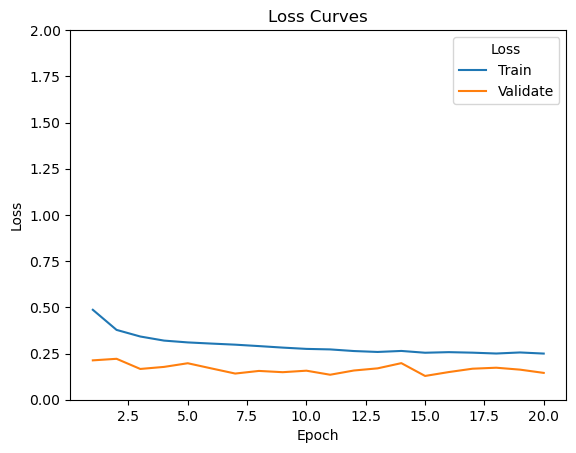

In [63]:
#Plot the training and validation losses

#Convert loss results into a dataframe
result_preproc = pd.DataFrame({
    'Epoch': [i+1 for i in range(len(results["loss"]))], 
    'Train': results["loss"],
    'Validate': results["val_loss"]
    })

# Convert dataframe from wide to long format
df = pd.melt(result_preproc, ['Epoch'])

#Make plot
g = sns.lineplot(data=df, x='Epoch', y='value', hue='variable')
g.set_title("Loss Curves")
g.legend_.set_title("Loss")
g.set_ylabel('Loss')
g.set_ylim(0, 2)

## 9) Predict Test Data

### 9.1 - Create a function to make reinitalization of test dataset easier

In [64]:
#Simple simple function to ititialize the test dataset using global variables
def init_test_dataset():
    return make_dataset(hdf5_file, test_meta_dict, test_pos_isic_id, test_pos_target, batch_size = test_batch_size, apply_hair_removal=apply_hair_removal)

### 9.2 - Retrieve y_test values

In [65]:
#Test dataset basic size information: nb of samples and batch size
nb_test_batches = int(np.ceil(len(test_meta_dict)/test_batch_size))
print("Total test batches in dataset:", nb_test_batches)

Total test batches in dataset: 2387


In [66]:
#Retrieve real values for the target in the test dataset
y_test = []
test_dataset = init_test_dataset()
for item in test_dataset.take(nb_test_batches):
    img_meta, targ = item
    y_test.extend(targ.numpy().flatten())
#Convert to numpy array (mathematical operations are faster)
y_test = np.array(y_test)

2024-10-27 07:28:53.630741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 9.3 - Generate predictions

In [67]:
#Reinitialize the test dataset (necessary to start at beginning)
test_dataset = init_test_dataset()
#Retrieve predictions
y_prob = model.predict(test_dataset, steps = nb_test_batches)
y_prob = y_prob.flatten()
#Put predictionsin a numpy array
y_pred = np.array([round(i) for i  in y_prob])
print("Shape of prediction data:", y_pred.shape)

2387/2387 [==============================] - 687s 288ms/step
Shape of prediction data: (76376,)


### 9.4 - Save y_test and y_pred in exported file

In [68]:
#Save test results to file
pd.DataFrame({"y_test": y_test, "y_prob": y_prob, "y_pred": y_pred}).to_csv(testResPath, index=False)

"""
#Import results from file
imported_test_results = pd.read_csv(testResPath)
y_test = np.array(imported_test_results["y_test"])
y_prob = np.array(imported_test_results["y_prob"])
y_pred = np.array(imported_test_results["y_pred"])
del imported_test_results
"""

'\n#Import results from file\nimported_test_results = pd.read_csv(testResPath)\ny_test = np.array(imported_test_results["y_test"])\ny_prob = np.array(imported_test_results["y_prob"])\ny_pred = np.array(imported_test_results["y_pred"])\ndel imported_test_results\n'

### 9.5 - Calculate metrics

In [69]:
#Calculate the loss
loss = sum(abs(y_test - y_pred))/len(y_pred)

In [70]:
#Determine true/false positives and negatives
pos_indices = y_test == 1
neg_indices = y_test == 0

#True positives
true_pos = sum(abs(y_test[pos_indices] == y_pred[pos_indices]))

#False negatives
false_neg = sum(abs(y_test[pos_indices] != y_pred[pos_indices]))

#True negatives
true_neg = sum(abs(y_test[neg_indices] == y_pred[neg_indices]))

#False positives
false_pos = sum(abs(y_test[neg_indices] != y_pred[neg_indices]))

#Precision
try:
    precision = true_pos / (true_pos + false_pos)
except:
    precision = np.nan

#Recall (sensitivity)
try:
    recall = true_pos / (true_pos + false_neg)
except:
    recall = np.nan

#Specificity
try:
    specificity = true_neg / (true_neg + false_pos)
except:
    specificity = np.nan

#F1 Score
try:
    f1_score = 2 * (precision * recall) / (precision + recall)
except:
    f1_score = np.nan

In [71]:
# AUC and partial AUC
precision_prob, recall_prob, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall_prob, precision_prob)
auc_roc = roc_auc_score(y_test, y_prob)
partial_auc_roc = auc_roc - roc_auc_score(y_test, y_prob, max_fpr=0.8)

In [72]:
print("---TEST RESULTS---")
print("True positives:", true_pos)
print("False positives:", false_pos)
print("True negatives:", true_neg)
print("False negatives:", false_neg)
print()
print("Sensitivity:", recall)
print("Specificity:", specificity)
print()
print("Precision:", precision)
print("Recall:", recall)
print()
print("F1 Score:", f1_score)
print("Loss on test data:", loss)
print()
print("AUC-ROC Score: ", auc_roc)
print("Partial AUC-ROC > 0.8: ", partial_auc_roc)
print("AUC-PR: ", auc_pr)

---TEST RESULTS---
True positives: 45
False positives: 3759
True negatives: 72548
False negatives: 24

Sensitivity: 0.6521739130434783
Specificity: 0.9507384643610678

Precision: 0.011829652996845425
Recall: 0.6521739130434783

F1 Score: 0.023237800154918664
Loss on test data: 0.04953126636639782

AUC-ROC Score:  0.8881991376178189
Partial AUC-ROC > 0.8:  0.0022859050356528465
AUC-PR:  0.02588650231107967


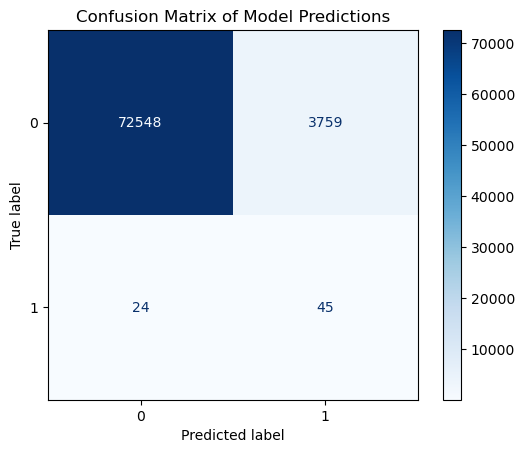

In [73]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Model Predictions")
plt.show()